In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Dense
from keras.callbacks import TensorBoard
import tensorflow as tf

In [ ]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

train_folder = "/kaggle/working/train_data"
train_set_folder = "/kaggle/working/train_set"
val_set_folder = "/kaggle/working/val_set"

class_folders = [f.path for f in os.scandir(train_folder) if f.is_dir()]

for class_folder in class_folders:
    class_name = os.path.basename(class_folder)
    images = [f.path for f in os.scandir(class_folder) if f.is_file()]
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    for image in train_images:
        dest_folder = os.path.join(train_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))

    for image in val_images:
        dest_folder = os.path.join(val_set_folder, class_name)
        os.makedirs(dest_folder, exist_ok=True)
        copyfile(image, os.path.join(dest_folder, os.path.basename(image)))



In [19]:
image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_gen.flow_from_directory("./train_data")


cv2.imread(image_gen.flow_from_directory("./train_data")[0])

Found 9990 images belonging to 10 classes.
Found 9990 images belonging to 10 classes.


TypeError: Can't convert object to 'str' for 'filename'

In [ ]:
### Custom model using CNN ###

model = Sequential()

input_shape = (150, 150, 3)

# add convolution layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# add flatten
model.add(Flatten())

# add dense layers
model.add(Dense(128, activation="sigmoid"))

# add drop out layer to help reduce over fitting by randomly turning neurons off during training
# model.add(Dropout(0.5))

# output layer
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# model summary
model.summary()

batch_size = 16
train_img_gen = image_gen.flow_from_directory("./train_data", target_size=input_shape[:2], batch_size=batch_size)

# class indices
print(train_img_gen.class_indices)

# fit the model
results = model.fit(train_img_gen, epochs=80, steps_per_epoch=600)


Found 9921 images belonging to 10 classes.
Found 4864 images belonging to 10 classes.
Epoch 1/30
310/310 [==============================] - 61s 191ms/step - loss: 1.8975 - accuracy: 0.3961 - val_loss: 1.3036 - val_accuracy: 0.5676
Epoch 2/30
310/310 [==============================] - 58s 187ms/step - loss: 1.2505 - accuracy: 0.5829 - val_loss: 0.9398 - val_accuracy: 0.7052
Epoch 3/30
310/310 [==============================] - 59s 189ms/step - loss: 0.9858 - accuracy: 0.6759 - val_loss: 0.7977 - val_accuracy: 0.7416
Epoch 4/30
310/310 [==============================] - 58s 188ms/step - loss: 0.7588 - accuracy: 0.7552 - val_loss: 0.4821 - val_accuracy: 0.8713
Epoch 5/30
310/310 [==============================] - 60s 193ms/step - loss: 0.5602 - accuracy: 0.8252 - val_loss: 0.4131 - val_accuracy: 0.8826
Epoch 6/30
310/310 [==============================] - 58s 186ms/step - loss: 0.4685 - accuracy: 0.8527 - val_loss: 0.3342 - val_accuracy: 0.9073
Epoch 7/30
310/310 [========================

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


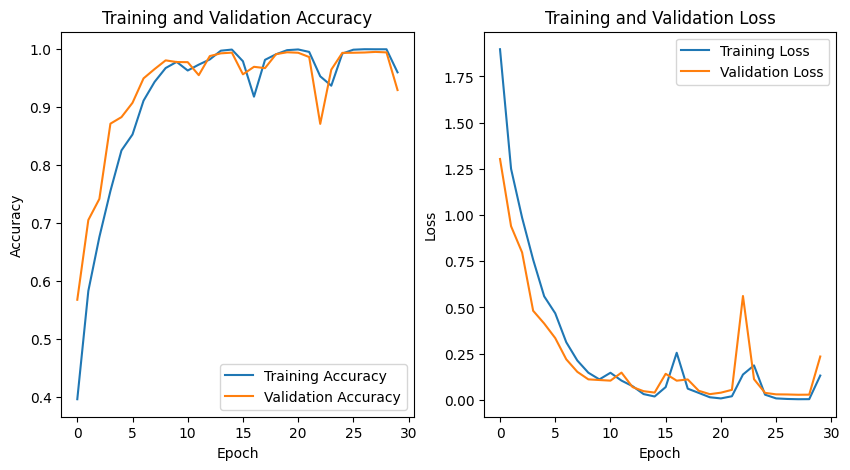

In [5]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten

### VGG16 model ### 

# Set the image size and number of classes
img_width, img_height = 224, 224
num_classes = 10

# Set up the data generators for training and validation
train_data_dir = './train_set/'
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

val_data_dir = './val_set'
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(img_width, img_height, 3))

base_model.trainable = True

# Freeze all the layers except for the last one
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Build a new model on top of the pre-trained VGG16 model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='ReLU'))
# Add dropout and another layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# log_dir = './logs' 
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
epochs = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs= epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size)

# Save the trained model
model.save('image_classifier.h5')

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [1]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

### ResNet50 model ### 

image_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_dir = './train_set'
image_gen.flow_from_directory(train_data_dir)


# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the base ResNet50 model and additional layers
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


train_img_gen = image_gen.flow_from_directory("./train_set", target_size=(224,224), batch_size=64)

# Train the model
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs= epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[callback, tensorboard_callback])

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
# model.fit(train_img_gen, batch_size=64, epochs=10, validation_data=val_img_gen, callbacks=[tensorboard_callback]) 

# Evaluate the model
# score = model.evaluate(x_test, y_test, verbose=0)



94765736/94765736 [==============================] - 1s 0us/step
Found 9921 images belonging to 10 classes.
Found 4864 images belonging to 10 classes.
Epoch 1/10
268/311 [========================>.....] - ETA: 16s - loss: 2.5501 - accuracy: 0.0975

KeyboardInterrupt: 